# How to read data in batches from TFRecords with TensorFlow Eager
----

Hello everyone, this tutorial is again focused on the input pipeline. It is quite simple, but I remember when I first started reading data in batches I got stuck in quite a few details so I thought that I might share my methods here. I really hope it will be useful for some of you.

We are going to work on two cases:
* **input data of variable sequence length** - in this case we will pad the batch on the fly to the biggest sequence length.
* **image data**


The data for both cases has been stored as TFRecords. You can have a look at the [**4th**](https://github.com/madalinabuzau/tensorflow-eager-tutorials/blob/master/04_text_data_to_tfrecords.ipynb) and [**5th**](https://github.com/madalinabuzau/tensorflow-eager-tutorials/blob/master/05_images_to_tfrecords.ipynb) tutorial to see how I transfer raw data to TFRecords.

So, let's jump right into coding :)!

### Import here useful libraries
----

In [2]:
# Import library for data visualization
import matplotlib.pyplot as plt

# Make the plots appear inline in the notebook
%matplotlib inline

# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [3]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution()

### Part 1: Reading data of variable sequence length
----
The first part of this tutorial shows you how to read input data that comes in different lengths. In our case, we used dummy IMDB reviews from the Large Movie Database. As you can imagine, each review has a different number of words. Therefore, when we will be reading a batch of data we will pad the sequences to the maximum sequence length within a batch.

To see how I obtained sequences of word indexes, along with the label and the sequence length please see [this tutorial](https://github.com/madalinabuzau/tensorflow-eager-tutorials/blob/master/04_text_data_to_tfrecords.ipynb).

### 1.1. Create function to parse each TFRecord
----

In [4]:
def parse_imdb_sequence(record):
    '''
    Script to parse imdb tfrecords.
    
    Returns:
        token_indexes: sequence of token indexes present in the review.
        target: the target of the movie review.
        sequence_length: the length of the sequence.
    '''
    context_features = {
        'sequence_length': tf.FixedLenFeature([], dtype=tf.int64),
        'target': tf.FixedLenFeature([], dtype=tf.int64),
        }
    sequence_features = {
        'token_indexes': tf.FixedLenSequenceFeature([], dtype=tf.int64),
        }
    context_parsed, sequence_parsed = tf.parse_single_sequence_example(record, 
        context_features=context_features, sequence_features=sequence_features)
        
    return (sequence_parsed['token_indexes'], context_parsed['target'],
            context_parsed['sequence_length'])

### 1.2. Create dataset iterator
----

As you can see in the function above, after parsing each record, we return a sequence of word indexes, the target of the review and the sequence length. In the method *padded_batch* we only pad the first element of the record: the sequence of word indexes. The target and sequence length do not need to be padded as they are just a single number, in each example. Thus, the padded_shapes will be:
* [None] -> pad the sequences to the largest dimension, unknown yet, therefore None.
* [ ] -> no padding for the target.
* [ ] -> no padding for the sequence length.


In [5]:
# Select here the batch size
batch_size = 2

# Create dataset from TFRecords
dataset = tf.data.TFRecordDataset('datasets/dummy_text/dummy.tfrecords')
dataset = dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
dataset = dataset.padded_batch(batch_size, padded_shapes=([None],[],[]))

### 1.3. Iterate through data once 
----

In [6]:
for review, target, sequence_length in tfe.Iterator(dataset):
    print(target)

tf.Tensor([0 1], shape=(2,), dtype=int64)
tf.Tensor([1 0], shape=(2,), dtype=int64)
tf.Tensor([0 1], shape=(2,), dtype=int64)


In [7]:
for review, target, sequence_length in tfe.Iterator(dataset):
    print(review.shape)

(2, 145)
(2, 139)
(2, 171)


In [8]:
for review, target, sequence_length in tfe.Iterator(dataset):
    print(sequence_length)

tf.Tensor([137 151], shape=(2,), dtype=int64)
tf.Tensor([139 171], shape=(2,), dtype=int64)
tf.Tensor([145 124], shape=(2,), dtype=int64)


### Part 2: Read images (and their labels) in batches
----

In the second part of the tutorial, we are going to visualize the images stored as TFRecords, by reading them in batches. These images are a small subsample from the FER2013 dataset.

### 2.1. Create function to parse each record and decode image
----

In [9]:
def parser(record):
    '''
    Function to parse a TFRecords example. 
    
    Returns:
        img: decoded image.
        label: the corresponding label of the image.         
    '''
    
    # Define here the features you would like to parse
    features = {'image': tf.FixedLenFeature((), tf.string),
                'label': tf.FixedLenFeature((), tf.int64)}
    
    # Parse example
    parsed = tf.parse_single_example(record, features)

    # Decode image 
    img = tf.image.decode_image(parsed['image'])
   
    return img, parsed['label']

### 2.2. Create dataset iterator
----

In [10]:
# Select here the batch size
batch_size = 5

# Create dataset from TFRecords
dataset = tf.data.TFRecordDataset('datasets/dummy_images/dummy.tfrecords')
dataset = dataset.map(parser).shuffle(buffer_size=10000)
dataset = dataset.batch(batch_size)

### 2.3. Iterate through dataset once. Visualize images.

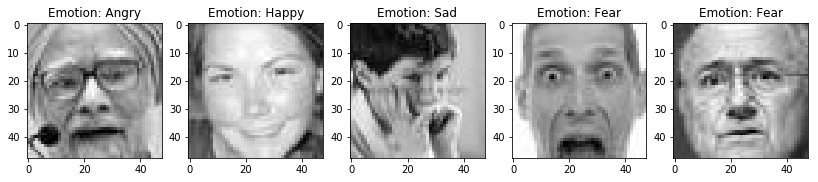

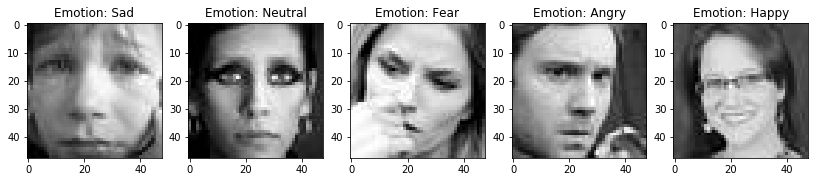

In [11]:
# Dictionary that stores the correspondence between integer labels and the emotions
emotion_cat = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

# Go through the dataset once
for image, label in tfe.Iterator(dataset):
    # Create a subplot for each batch of images
    f, axarr = plt.subplots(1, int(image.shape[0]), figsize=(14, 6))
    # Plot images
    for i in range(image.shape[0]):
        axarr[i].imshow(image[i,:,:,0], cmap='gray')
        axarr[i].set_title('Emotion: %s' %emotion_cat[label[i].numpy()])